In [1]:
from fastai.vision.all import *
from fastai.data.transforms import *
import matplotlib.pyplot as plt
from PIL import ImageOps

## I am processing data from many different track sessions so we are trying to make a generalised model instead of a specific one

In [2]:
path = 'data/'
csv = path + '/labels.csv'
np.random.seed(42)

In [3]:
tubs = [ 'Andrew Kew traffic School/tub_11_19-11-03', 'andrew_zen', 'Buzadaza Town Hall/tub_2_19-07-13', 'Carpark_yellow_rope/tub_9_19-07-20', 'Carpark_yellow_rope/tub_15_19-07-20', 
        'Carpark_yellow_rope/tub_20_19-08-25', 'Kew Traffic School Small Track/tub_27_19-11-04', 'kew_traffic_school-19-12-28/tub_33_19-12-28' 'kew_traffic_school-19-12-28/tub_35_19-12-28'  ]


In [4]:
def load_donkey_tub(path, tubs):
    df = pd.DataFrame({'image': pd.Series([], dtype='str'),
                       'angle': pd.Series([], dtype='float'),
                       'throttle': pd.Series([], dtype='float')})
    for tub in tubs:
        dir = path + tub + '/'
        print("Directory: " + dir)
        for file in glob.glob(dir + '*.json'):
            data = {}
            with open(file, 'r') as fh:
                data = json.load(fh)
                if ('cam/image_array' in data.keys()):
                    image = dir  + data['cam/image_array']
                    angle = float(data['user/angle'])
                    throttle = float(data['user/throttle'])
                    #print(image + ' ' + str(angle) + ' ' + str(throttle))
                    new_row = { 'image':str(image), 'angle':angle, 'throttle':throttle }
                    df = df.append(new_row, ignore_index=True)
                    #print(df.head())
    return df

In [5]:
df = load_donkey_tub(path, tubs)
df.head()


Directory: data/Andrew Kew traffic School/tub_11_19-11-03/


KeyboardInterrupt: 

In [ ]:
df.to_csv('donkey_linear.csv')

### Loading Data as it takes ages

In [4]:
df = pd.read_csv('donkey_linear.csv')
print(df.shape)
df.head()

(56845, 4)


,Unnamed: 0,image,angle,throttle
0,0,data/Andrew Kew traffic School/tub_11_19-11-03/1443_cam-image_array_.jpg,-0.000454,0.417823
1,1,data/Andrew Kew traffic School/tub_11_19-11-03/2625_cam-image_array_.jpg,0.171708,0.508301
2,2,data/Andrew Kew traffic School/tub_11_19-11-03/9651_cam-image_array_.jpg,0.094192,0.499684
3,3,data/Andrew Kew traffic School/tub_11_19-11-03/414_cam-image_array_.jpg,-0.118767,0.404898
4,4,data/Andrew Kew traffic School/tub_11_19-11-03/9713_cam-image_array_.jpg,1.000000,0.495375


### We need to filter the throttle above 0 as we have some bad data we also plot the throttle and angle

In [7]:
df = df[df.throttle > 0]
df.shape

(56842, 4)

0   -0.000454
1    0.171708
2    0.094192
3   -0.118767
4    1.000000
Name: angle, dtype: float64

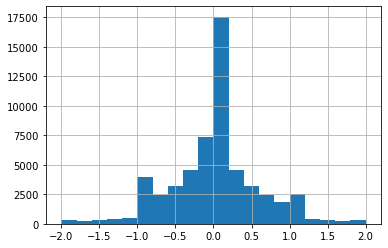

In [8]:
plt.figure()
df.angle.diff().hist(bins=20)
df.angle.head()
# Angles

0    0.417823
1    0.508301
2    0.499684
3    0.404898
4    0.495375
Name: throttle, dtype: float64

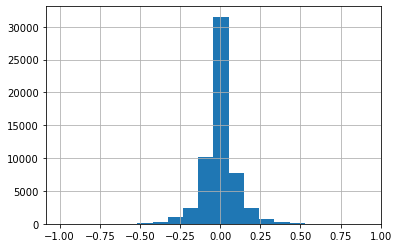

In [9]:
plt.figure()
df.throttle.diff().hist(bins=20)
df.throttle.head()
# Throttle

In [10]:
#dls = ImageDataLoaders.from_df(df, '', fn_col=1, label_col=[2,3], y_block= RegressionBlock(n_out=2), 
#                               bs=128, seed=42)

In [5]:
class RandFlip(RandTransform):
    def __init__(self, p=1.0, **kwargs):
        super().__init__(p, **kwargs)
    def encodes(self, o: Tensor): 
        return Tensor([-o[0], o[1]])   # this reverses the target steering value
    def encodes(self, o: PILImage):
        return ImageOps.mirror(o)     # this mirrors the input image

In [22]:
nav = DataBlock(
    blocks=(ImageBlock(cls=PILImage) , RegressionBlock(n_out=2)),
    get_x=ColReader('image', pref=''), 
    get_y=ColReader(['angle','throttle'])  ,
    splitter=RandomSplitter(0.2, seed=42), #split 20% of the time for test set
    #item_tfms=[RandFlip(.5)],
    #batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, 
    #                          min_zoom=0, max_zoom=0, max_warp=0, p_affine=0, xtra_tfms=Normalize()) 
)
dls = nav.dataloaders(df, bs=256)

In [34]:
dls.c

2

In [35]:
dls.show

<bound method Datasets.show of (#45474) [(PILImage mode=RGB size=160x120, tensor([0.0000, 0.2056])),(PILImage mode=RGB size=160x120, tensor([0.0000, 0.1858])),(PILImage mode=RGB size=160x120, tensor([0.2134, 0.1621])),(PILImage mode=RGB size=160x120, tensor([0.0000, 0.2214])),(PILImage mode=RGB size=160x120, tensor([-0.7046,  0.2793])),(PILImage mode=RGB size=160x120, tensor([0.0000, 0.1937])),(PILImage mode=RGB size=160x120, tensor([0.0000, 0.2056])),(PILImage mode=RGB size=160x120, tensor([0.0000, 0.1542])),(PILImage mode=RGB size=160x120, tensor([-0.1106,  0.4566])),(PILImage mode=RGB size=160x120, tensor([0.1055, 0.4002]))...]>

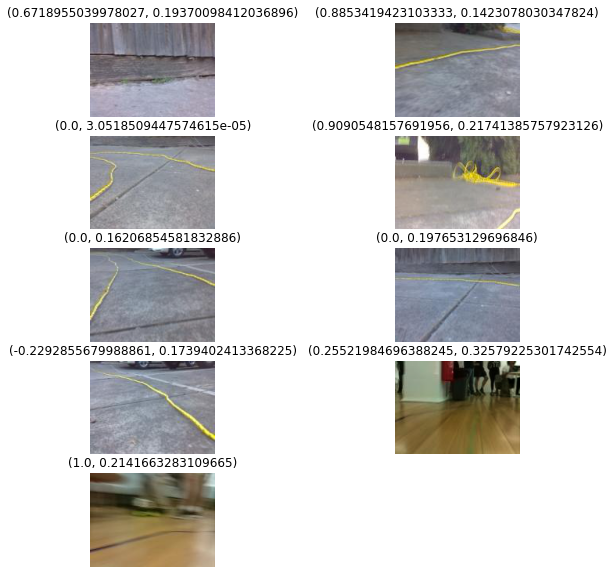

In [36]:
dls.show_batch(nrows=5,ncols=2,figsize=(10,10))


### A reinterpratiaton of the Donkey Cars Linear model from Tensorflow to PyTorch 
https://github.com/autorope/donkeycar/blob/dev/donkeycar/parts/keras.py

### Tensorflow
def default_n_linear(num_outputs, input_shape=(120, 160, 3), roi_crop=(0, 0)):

    drop = 0.1

    #we now expect that cropping done elsewhere. we will adjust our expeected image size here:
    input_shape = adjust_input_shape(input_shape, roi_crop)
    
    img_in = Input(shape=input_shape, name='img_in')
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)
    x = Dropout(drop)(x)
    
    x = Flatten(name='flattened')(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(drop)(x)

    outputs = []
    
    for i in range(num_outputs):
        outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
    model = Model(inputs=[img_in], outputs=outputs)
    
    return model

In [27]:
# Pytorch
class DonkeycarLinear(nn.Module):
    def __init__(self):
        super(DonkeycarLinear, self).__init__()
        self.dropout = 0.1
        # init the layers
        self.conv24 = nn.Conv2d(3, 24, kernel_size=(5,5), stride=(2,2))
        self.conv32 = nn.Conv2d(24, 32, kernel_size=(5,5), stride=(2,2))
        self.conv64_5 = nn.Conv2d(32, 64, kernel_size=(5,5), stride=(2,2))
        self.conv64_3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1))
        self.fc1 = nn.Linear(64 * 8 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.drop = nn.Dropout(self.dropout)
        self.relu = nn.ReLU()
        self.output = nn.Linear(50, 2)
        self.flatten = nn.Flatten()
        
        
    def forward(self, x):
        x = self.relu(self.conv24(x))
        x = self.drop(x)
        x = self.relu(self.conv32(x))
        x = self.drop(x)
        x = self.relu(self.conv64_5(x))
        x = self.drop(x)        
        x = self.relu(self.conv64_3(x))
        x = self.drop(x)
        x = self.relu(self.conv64_3(x))
        x = self.drop(x)        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        
        return self.output(x)

In [28]:
model = DonkeycarLinear()

In [54]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse, accuracy_multi], cbs=ActivationStats(with_hist=True))
learn.summary()
print(learn.loss_func)


FlattenedLoss of MSELoss()


Minimum/10: 2.51e-04, steepest point: 9.12e-07


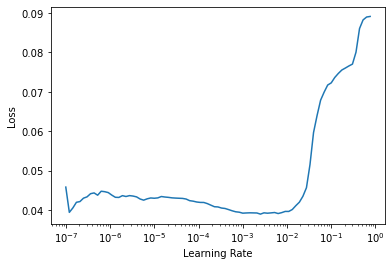

In [55]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [31]:
learn.fit_one_cycle(15, 2.09e-04)
                    #cbs=SaveModelCallback(every_epoch=True))


epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.110881,0.105482,0.324780,0.695444,01:56
1,0.098980,0.100729,0.317378,0.758950,02:00
2,0.092958,0.093755,0.306194,0.734277,02:02
3,0.087520,0.084233,0.290230,0.740522,02:02
4,0.077434,0.070512,0.265541,0.738236,02:00
5,0.065193,0.060563,0.246096,0.756311,01:59
6,0.058966,0.058316,0.241488,0.752309,02:00
7,0.055553,0.054860,0.234222,0.751385,02:00
8,0.053986,0.052718,0.229605,0.754112,02:00
9,0.052641,0.051689,0.227353,0.751209,02:00


In [ ]:
donkey_model_linear with no aug
epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.104955	0.100959	0.317741	0.807046	01:51
1	0.098518	0.091548	0.302569	0.743842	01:57
2	0.087582	0.081167	0.284898	0.769001	02:00
3	0.075820	0.073933	0.271905	0.766890	01:57
4	0.060681	0.057462	0.239713	0.774587	01:56
5	0.053481	0.052335	0.228769	0.783427	01:55
6	0.049139	0.046913	0.216593	0.774323	01:56
7	0.045587	0.045332	0.212913	0.772563	01:55
8	0.043420	0.042610	0.206422	0.771376	01:55
9	0.042063	0.041215	0.203014	0.778765	01:54
10	0.040611	0.039893	0.199732	0.774587	01:54
11	0.040065	0.039446	0.198609	0.781624	01:55
12	0.038801	0.039337	0.198335	0.782152	01:55
13	0.038833	0.038688	0.196693	0.782020	01:55
14	0.038933	0.038699	0.196720	0.781668	01:55

In [ ]:
batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, min_zoom=0, max_zoom=0, max_warp=0, p_affine=0)
epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.109576	0.105608	0.324974	0.804996	01:52
1	0.097748	0.101606	0.318757	0.771616	01:58
2	0.088988	0.085804	0.292924	0.762688	02:00
3	0.078677	0.074785	0.273468	0.764139	01:59
4	0.064519	0.058877	0.242646	0.766778	01:56
5	0.055288	0.053797	0.231942	0.750242	01:55
6	0.050933	0.048434	0.220077	0.760269	01:54
7	0.048203	0.046681	0.216059	0.764755	01:54
8	0.044725	0.044707	0.211440	0.770516	01:54
9	0.044118	0.043177	0.207790	0.766250	01:54
10	0.043507	0.041977	0.204883	0.773067	01:55
11	0.041712	0.042323	0.205725	0.763875	01:54
12	0.040981	0.041226	0.203042	0.770296	01:55
13	0.040471	0.040752	0.201872	0.766998	01:55
14	0.040363	0.040761	0.201893	0.767394	01:55

In [ ]:
    item_tfms=[RandFlip(.3)],
    batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, min_zoom=0, max_zoom=0, max_warp=0, p_affine=0)

epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.110250	0.105421	0.324686	0.804600	01:54
1	0.099366	0.099902	0.316073	0.736125	02:00
2	0.093400	0.090186	0.300309	0.751561	02:03
3	0.087003	0.081949	0.286268	0.753540	01:59
4	0.076113	0.067338	0.259496	0.753188	01:59
5	0.063908	0.056808	0.238344	0.758554	01:57
6	0.060133	0.052742	0.229656	0.757718	01:58
7	0.056883	0.050631	0.225013	0.761061	01:57
8	0.053661	0.049388	0.222235	0.757982	02:00
9	0.053578	0.047860	0.218769	0.763875	02:01
10	0.051250	0.045817	0.214048	0.761281	02:01
11	0.049550	0.045275	0.212779	0.763788	02:01
12	0.049280	0.044744	0.211527	0.761720	02:01
13	0.048931	0.044532	0.211026	0.761808	02:02
14	0.048471	0.044500	0.210951	0.762336	02:01

In [ ]:
    item_tfms=[RandFlip(.5)],
    batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, min_zoom=0, max_zoom=0, max_warp=0, p_affine=0)


epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.110881	0.105482	0.324780	0.695444	01:56
1	0.098980	0.100729	0.317378	0.758950	02:00
2	0.092958	0.093755	0.306194	0.734277	02:02
3	0.087520	0.084233	0.290230	0.740522	02:02
4	0.077434	0.070512	0.265541	0.738236	02:00
5	0.065193	0.060563	0.246096	0.756311	01:59
6	0.058966	0.058316	0.241488	0.752309	02:00
7	0.055553	0.054860	0.234222	0.751385	02:00
8	0.053986	0.052718	0.229605	0.754112	02:00
9	0.052641	0.051689	0.227353	0.751209	02:00
10	0.051039	0.049616	0.222746	0.764975	02:01
11	0.050231	0.048817	0.220947	0.756399	02:02
12	0.049209	0.048651	0.220570	0.764579	02:02
13	0.049425	0.048159	0.219451	0.763656	02:04
14	0.048876	0.047938	0.218948	0.762116	02:02

In [33]:
learn.save('donkey_model_linear')

Path('models/donkey_model_linear.pth')

In [26]:
def plot_loss_stats(learn):
    learn.recorder.plot_loss()
    #learn.activation_stats.plot_layer_stats(-2)
    learn.show_results(nrows=5,ncbols=2,figsize=(10,10))

AttributeError: 'AxesImage' object has no property 'ncbols'

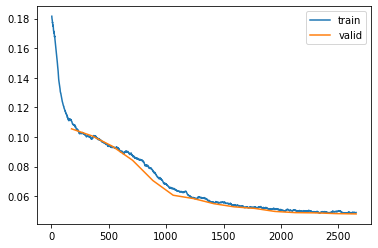

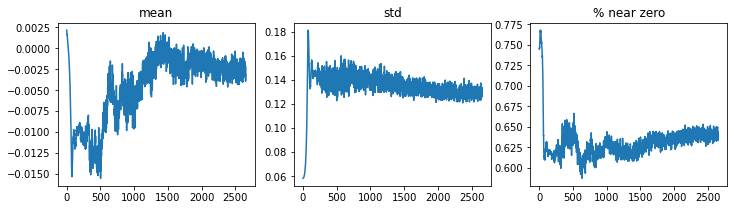

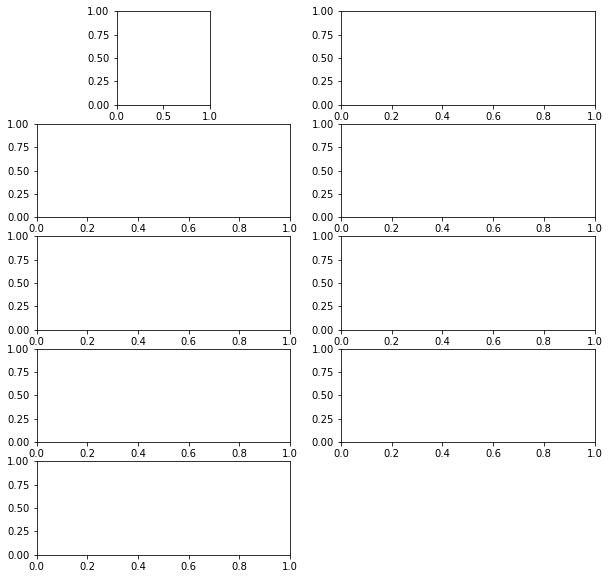

In [35]:
plot_loss_stats(learn)

In [10]:
def graph_preds(dls):
    dls = nav.dataloaders(df, bs=1256)
    preds, tgt = learn.get_preds(dl=[dls.one_batch()])
    print(preds.shape)

    #Steering
    plt.title("Target vs Predicted Steering", fontsize=18, y=1.0)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[0], preds.T[0],'bo')
    plt.plot([-1,1],[-1,1],'r', linewidth = 4)
    plt.show()
    
    #Throttle
    plt.title("Target vs Predicted Throttle", fontsize=18, y=1.02)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[1], preds.T[1],'bo')
    plt.plot([0,1],[0,1],'r', linewidth = 4)
    plt.show()    

torch.Size([2000, 2])


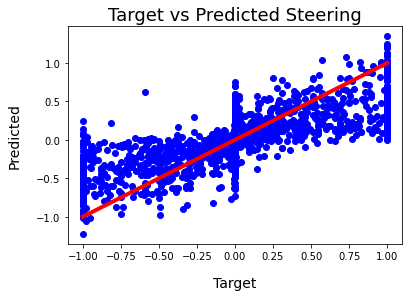

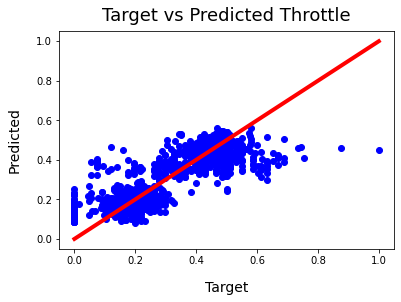

In [37]:
graph_preds(dls)

In [38]:
### Testing Model https://github.com/cmasenas/fastai_navigation_training/blob/master/fastai_train.ipynb

In [12]:
model = nn.Sequential(
        ConvLayer(3, 16, stride=2),
        ConvLayer(16, 32, stride=2),
        ConvLayer(32, 64, stride=2),
        ConvLayer(64, 128, stride=2),
        ConvLayer(128, 256, stride=2),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [13]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse, accuracy_multi], cbs=ActivationStats(with_hist=True))
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 16 x 60 x 80   432        True      
________________________________________________________________
BatchNorm2d          256 x 16 x 60 x 80   32         True      
________________________________________________________________
ReLU                 256 x 16 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 32 x 30 x 40   4,608      True      
________________________________________________________________
BatchNorm2d          256 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 256 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               256 x 64 x 15 x 20   18,432     True      
________________________________________________

Minimum/10: 3.31e-03, steepest point: 6.92e-04


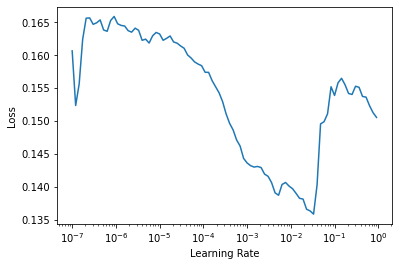

In [58]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [59]:
learn.fit_one_cycle(15, 3.31e-03)

epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.080998,0.078980,0.281034,0.714575,03:19
1,0.069204,0.066780,0.258418,0.731727,03:18
2,0.057877,0.062888,0.250774,0.766690,03:14
3,0.051509,0.054670,0.233817,0.756619,03:14
4,0.048883,0.050663,0.225085,0.766866,03:15
5,0.047118,0.048225,0.219602,0.757762,03:17
6,0.042530,0.055136,0.234810,0.754200,03:17
7,0.039435,0.042522,0.206209,0.759961,03:18
8,0.036567,0.041516,0.203754,0.772979,03:13
9,0.034842,0.042987,0.207333,0.767438,03:14


In [1]:
plot_loss_stats(learn)

NameError: name 'plot_loss_stats' is not defined

In [ ]:
graph_preds(dls)

### My Experimental Version

In [16]:
model = nn.Sequential(
        ConvLayer(3, 24, stride=2, ks=5),
        ConvLayer(24, 32, stride=2, ks=5),
        ConvLayer(32, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=3),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        LinBnDrop(64, 256),
        LinBnDrop(256, dls.c))

In [17]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse, accuracy_multi], cbs=ActivationStats(with_hist=True))
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 24 x 60 x 80   1,800      True      
________________________________________________________________
BatchNorm2d          256 x 24 x 60 x 80   48         True      
________________________________________________________________
ReLU                 256 x 24 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 32 x 30 x 40   19,200     True      
________________________________________________________________
BatchNorm2d          256 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 256 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               256 x 64 x 15 x 20   51,200     True      
________________________________________________

Minimum/10: 1.10e-03, steepest point: 1.74e-01


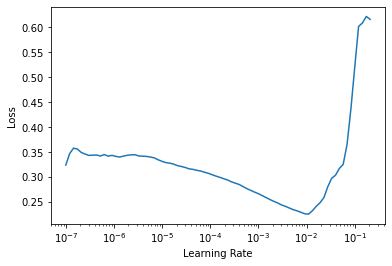

In [18]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [19]:
learn.fit_one_cycle(15, 1.10e-03)

epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.119279,0.102524,0.320194,0.707230,03:58
1,0.079106,0.077970,0.279230,0.762732,03:55
2,0.068896,0.062776,0.250552,0.750770,03:58
3,0.057294,0.056230,0.237129,0.757894,04:00
4,0.050154,0.050407,0.224516,0.767570,04:01
5,0.045946,0.046186,0.214909,0.786745,04:01
6,0.043405,0.067504,0.259815,0.792990,04:01
7,0.039812,0.043679,0.208995,0.756575,04:00
8,0.036539,0.040845,0.202102,0.776366,04:01
9,0.034081,0.040368,0.200918,0.766778,04:02


AttributeError: 'AxesImage' object has no property 'ncbols'

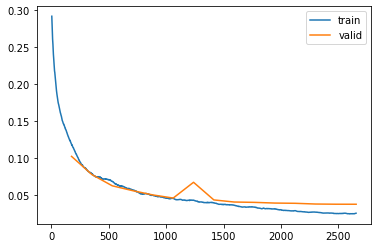

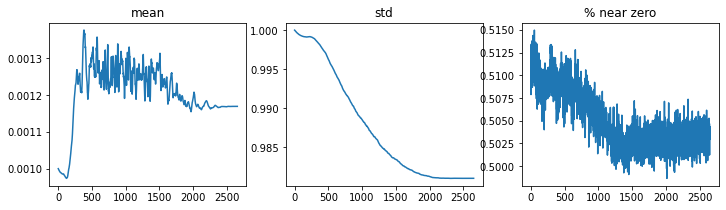

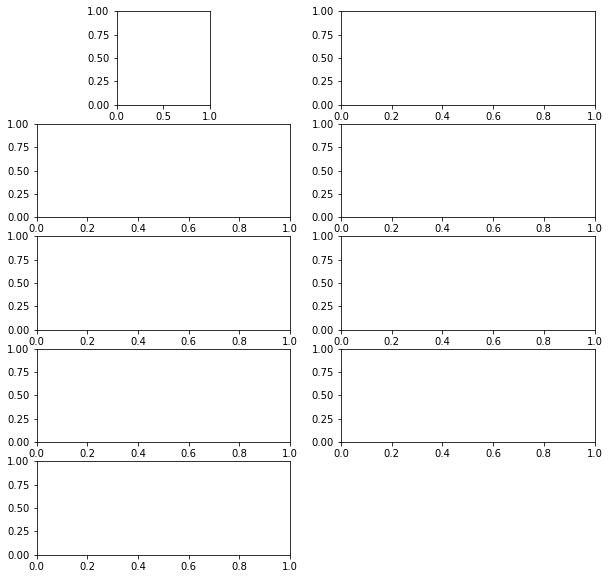

In [23]:
plot_loss_stats(learn)

torch.Size([2000, 2])


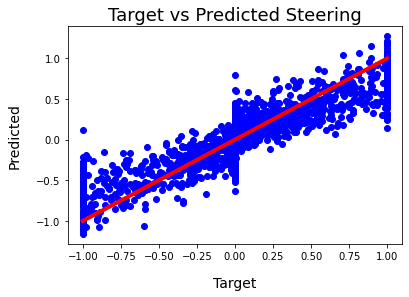

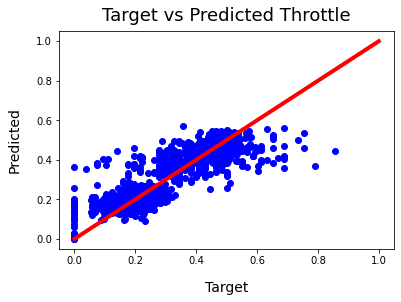

In [24]:
graph_preds(dls)

### Model with one less Linear layer

In [18]:
model = nn.Sequential(
        ConvLayer(3, 24, stride=2, ks=5),
        ConvLayer(24, 32, stride=2, ks=5),
        ConvLayer(32, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=3),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        LinBnDrop(64, dls.c))

In [19]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse, accuracy_multi])
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 24 x 60 x 80   1,800      True      
________________________________________________________________
BatchNorm2d          256 x 24 x 60 x 80   48         True      
________________________________________________________________
ReLU                 256 x 24 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 32 x 30 x 40   19,200     True      
________________________________________________________________
BatchNorm2d          256 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 256 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               256 x 64 x 15 x 20   51,200     True      
________________________________________________

Minimum/10: 8.32e-03, steepest point: 1.74e-05


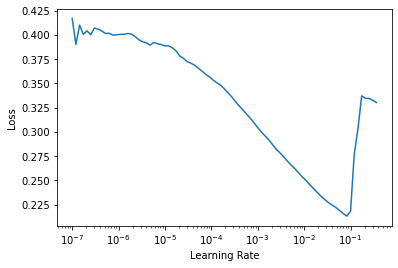

In [20]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn.fit_one_cycle(15, 1.10e-02)

epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.089651,0.084041,0.289899,0.756927,03:48
1,0.064011,0.072985,0.270157,0.796948,03:52
2,0.053852,0.085477,0.292365,0.760753,03:46
3,0.051158,0.070176,0.264908,0.795453,03:41
4,0.046752,0.048529,0.220293,0.738236,03:37
5,0.044316,0.048060,0.219226,0.774430,03:33
6,0.041541,0.043226,0.207908,0.779092,03:31
7,0.038254,0.039107,0.197755,0.763260,03:31
8,0.035481,0.043913,0.209555,0.722975,03:32
9,0.032481,0.036949,0.192222,0.768449,03:35


In [ ]:
# with no aug
epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.075440	0.073709	0.271495	0.782699	04:13
1	0.053316	0.062552	0.250104	0.722095	04:13
2	0.047172	0.051099	0.226050	0.730451	04:08
3	0.042502	0.046186	0.214908	0.739819	04:09
4	0.040705	0.044962	0.212042	0.762204	04:08
5	0.036946	0.042204	0.205436	0.783226	04:02
6	0.034307	0.038972	0.197414	0.784634	04:01
7	0.029642	0.038011	0.194965	0.737180	03:58
8	0.026952	0.035074	0.187279	0.743117	04:09
9	0.023162	0.035164	0.187521	0.772847	04:48
10	0.018871	0.034315	0.185243	0.763436	04:51
11	0.015042	0.034376	0.185408	0.757147	04:33
12	0.012219	0.033879	0.184062	0.767174	04:12
13	0.010355	0.034076	0.184596	0.762380	04:14
14	0.009579	0.034438	0.185575	0.755168	04:11

#with Aug

epoch	train_loss	valid_loss	_rmse	accuracy_multi	time
0	0.089651	0.084041	0.289899	0.756927	03:48
1	0.064011	0.072985	0.270157	0.796948	03:52
2	0.053852	0.085477	0.292365	0.760753	03:46
3	0.051158	0.070176	0.264908	0.795453	03:41
4	0.046752	0.048529	0.220293	0.738236	03:37
5	0.044316	0.048060	0.219226	0.774430	03:33
6	0.041541	0.043226	0.207908	0.779092	03:31
7	0.038254	0.039107	0.197755	0.763260	03:31
8	0.035481	0.043913	0.209555	0.722975	03:32
9	0.032481	0.036949	0.192222	0.768449	03:35
10	0.030408	0.036911	0.192122	0.786525	03:35

# xresnet18

In [6]:
nav = DataBlock(
    blocks=(ImageBlock(cls=PILImage) , RegressionBlock(n_out=2)),
    get_x=ColReader('image', pref=''), 
    get_y=ColReader(['angle','throttle'])  ,
    splitter=RandomSplitter(0.2, seed=42), #split 20% of the time for test set
    item_tfms=[RandFlip(.5)],
    batch_tfms=aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, 
                              min_zoom=0, max_zoom=0, max_warp=0, p_affine=0, xtra_tfms=Normalize()) 
)
dls = nav.dataloaders(df, bs=256)

In [7]:
learn = cnn_learner(dls, xresnet18, metrics=[rmse, accuracy_multi])
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 32 x 60 x 80   864        False     
________________________________________________________________
BatchNorm2d          256 x 32 x 60 x 80   64         True      
________________________________________________________________
ReLU                 256 x 32 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 32 x 60 x 80   9,216      False     
________________________________________________________________
BatchNorm2d          256 x 32 x 60 x 80   64         True      
________________________________________________________________
ReLU                 256 x 32 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 64 x 60 x 80   18,432     False     
________________________________________________

Minimum/10: 6.92e-03, steepest point: 2.29e-02


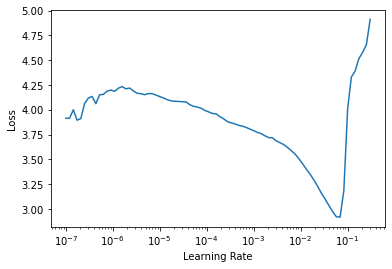

In [34]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [35]:
learn.fit_one_cycle(10, 2.29e-02)

epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.324746,0.088684,0.297798,0.776410,01:01
1,0.125404,0.075968,0.275623,0.754244,01:01
2,0.074511,0.053508,0.231319,0.739555,01:02
3,0.054254,0.051529,0.227000,0.765503,01:02
4,0.048776,0.049853,0.223277,0.755475,01:02
5,0.045768,0.043714,0.209080,0.769593,01:02
6,0.043763,0.041620,0.204009,0.781819,01:02
7,0.040766,0.038506,0.196230,0.769417,01:00
8,0.038272,0.037477,0.193591,0.769241,00:59
9,0.037962,0.037550,0.193779,0.763524,00:59


In [36]:
learn.save('xresnet18')

Path('models/xresnet18.pth')

In [8]:
learn.load('xresnet18')

Minimum/10: 1.32e-07, steepest point: 1.10e-06


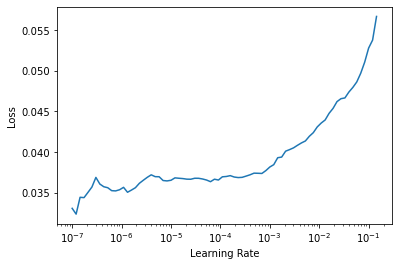

In [11]:
learn.unfreeze()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [12]:
learn.fine_tune(5, 1.32e-07)

epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.036790,0.037433,0.193476,0.764007,00:59


epoch,train_loss,valid_loss,_rmse,accuracy_multi,time
0,0.036676,0.037465,0.193560,0.763216,01:15
1,0.036616,0.037344,0.193245,0.765723,01:14
2,0.037004,0.037426,0.193459,0.764975,01:14
3,0.037155,0.037389,0.193361,0.764975,01:14
4,0.036649,0.037504,0.193659,0.764579,01:14


In [13]:
learn.save('xresnet18_fine')

Path('models/xresnet18_fine.pth')

In [8]:
learn.load('xresnet18_fine')

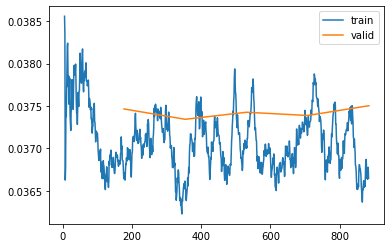

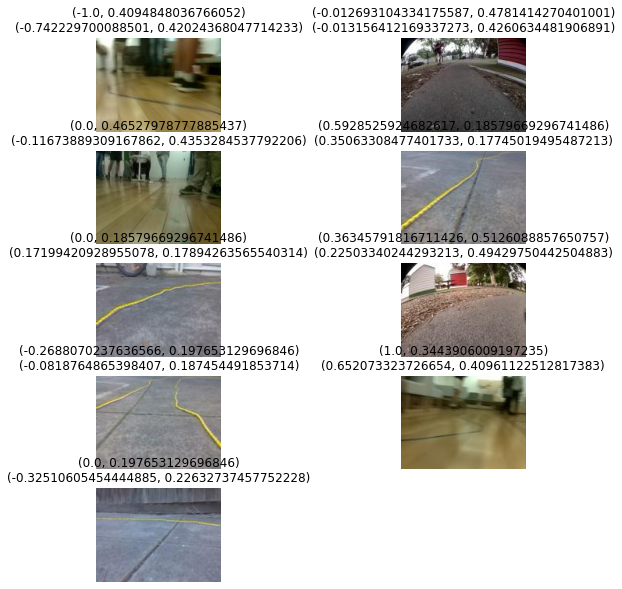

In [14]:
#plot_loss_stats(learn)
learn.recorder.plot_loss()
learn.show_results(nrows=5, figsize=(10,10))

torch.Size([1256, 2])


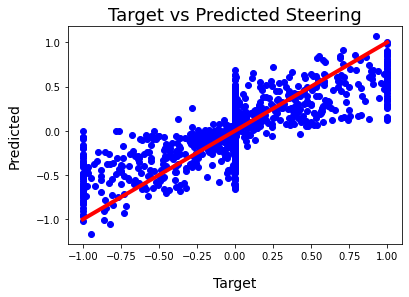

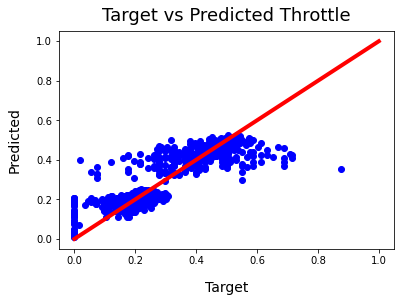

In [11]:
graph_preds(dls)